In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Bidirectional, LSTM

import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

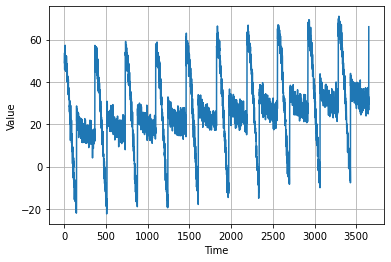

In [4]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plot_series(time, series)

In [5]:
print('train shape : ', x_train.shape)
print('validation shape : ', x_valid.shape)

train shape :  (3000,)
validation shape :  (651,)


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

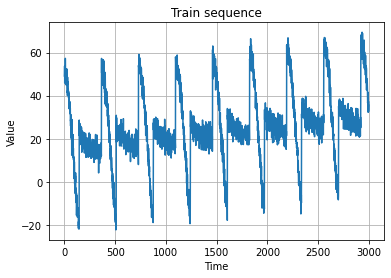

In [7]:
plot_series(time_train, x_train)
plt.title('Train sequence');

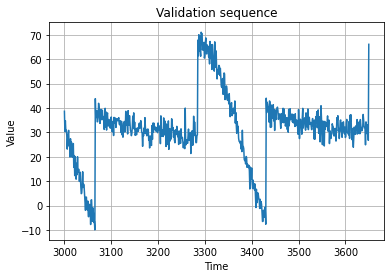

In [8]:
plot_series(time_valid, x_valid)
plt.title('Validation sequence');

In [9]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [10]:
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [17]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.ld = Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None])
    self.lstm1 = Bidirectional(LSTM(32, return_sequences=True))
    self.lstm2 = Bidirectional(LSTM(32, return_sequences=True))
    self.lstm3 = Bidirectional(LSTM(32))
    self.d1 = Dense(1)

  def call(self, x):
    x = self.ld(x)
    x = self.lstm1(x)
    x = self.lstm2(x)
    x = self.lstm3(x)
    x = self.d1(x)
    return x
  
  def model(self):
    x = Input([window_size])
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [20]:
tf.keras.backend.clear_session()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model = MyModel()
model.compile(loss='mse', optimizer=optimizer)
model.model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
lambda (Lambda)              (None, 20, 1)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 64)            8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 64)            24832     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 58,433
Trainable params: 58,433
Non-trainable params: 0
__________________________________________________

In [21]:
epochs = 100
history = model.fit(train_dataset, epochs = epochs, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 3s 37ms/step - loss: 895.9266
Epoch 2/100
94/94 [==============================] - 4s 38ms/step - loss: 895.3063
Epoch 3/100
94/94 [==============================] - 3s 37ms/step - loss: 894.6013
Epoch 4/100
94/94 [==============================] - 4s 38ms/step - loss: 893.8143
Epoch 5/100
94/94 [==============================] - 4s 39ms/step - loss: 892.9272
Epoch 6/100
94/94 [==============================] - 4s 37ms/step - loss: 891.9362
Epoch 7/100
94/94 [==============================] - 3s 37ms/step - loss: 890.8250
Epoch 8/100
94/94 [==============================] - 3s 37ms/step - loss: 889.5748
Epoch 9/100
94/94 [==============================] - 4s 37ms/step - loss: 888.1732
Epoch 10/100
94/94 [==============================] - 4s 38ms/step - loss: 886.6033
Epoch 11/100
94/94 [==============================] - 4s 38ms/step - loss: 884.8456
Epoch 12/100
94/94 [==============================] - 4s 38ms/step - loss: 882.8803
E

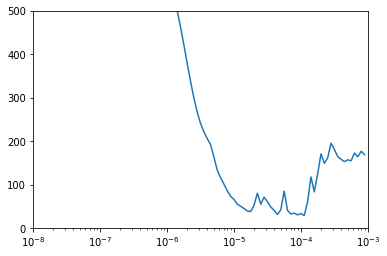

In [22]:
plt.semilogx(1e-8 * (10 ** (np.arange(100) / 20)), history.history['loss'][:100])
plt.axis([1e-8, 1e-3, 0, 500]);

In [23]:
argmin = tf.argmin(history.history['loss']).numpy()
argmin

81

In [25]:
new_lr = 1e-8 * (10 ** ((argmin+1) / 20))
new_lr

0.00012589254117941664

In [28]:
tf.keras.backend.clear_session()
optimizer = tf.keras.optimizers.SGD(lr=new_lr, momentum=0.9)

model = MyModel()
model.compile(loss='mse', optimizer=optimizer)
model.model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
lambda (Lambda)              (None, 20, 1)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 64)            8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 64)            24832     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 58,433
Trainable params: 58,433
Non-trainable params: 0
__________________________________________________

In [29]:
epochs = 500
history = model.fit(train_dataset, epochs = epochs)

Epoch 1/500
94/94 [==============================] - 3s 37ms/step - loss: 304.1422
Epoch 2/500
94/94 [==============================] - 4s 41ms/step - loss: 132.5633
Epoch 3/500
94/94 [==============================] - 3s 37ms/step - loss: 97.5406
Epoch 4/500
94/94 [==============================] - 4s 37ms/step - loss: 145.8990
Epoch 5/500
94/94 [==============================] - 4s 38ms/step - loss: 147.5767
Epoch 6/500
94/94 [==============================] - 4s 37ms/step - loss: 199.8097
Epoch 7/500
94/94 [==============================] - 4s 38ms/step - loss: 142.2092
Epoch 8/500
94/94 [==============================] - 4s 38ms/step - loss: 160.7614
Epoch 9/500
94/94 [==============================] - 4s 38ms/step - loss: 131.1832
Epoch 10/500
94/94 [==============================] - 4s 38ms/step - loss: 137.5016
Epoch 11/500
94/94 [==============================] - 4s 38ms/step - loss: 122.7165
Epoch 12/500
94/94 [==============================] - 4s 38ms/step - loss: 139.1071
Ep

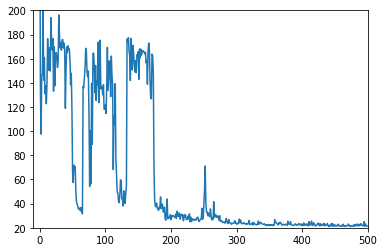

In [34]:
plt.plot(history.history['loss'])
plt.axis([-10, 500, 20, 200]);

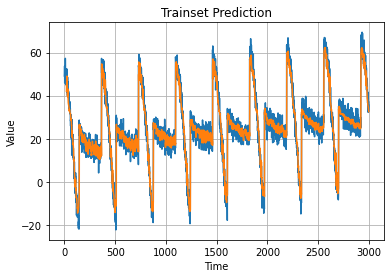

In [35]:
train_dataset = windowed_dataset(x_train, window_size, batch_size, 1)
train_preds = np.array([])
for i in train_dataset:
  train_preds = np.append(train_preds, model(i[0]).numpy())
plot_series(time_train, x_train)
plot_series(time_train[20:], train_preds)
plt.title('Trainset Prediction');

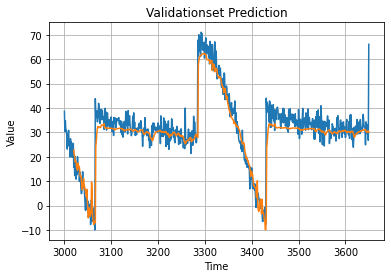

In [36]:
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, 1)
valid_preds = np.array([])
for i in valid_dataset:
  valid_preds = np.append(valid_preds, model(i[0]).numpy())
plot_series(time_valid, x_valid)
plot_series(time_valid[20:], valid_preds)
plt.title('Validationset Prediction');

In [37]:
print('Train MAE : ', tf.keras.metrics.mean_absolute_error(x_train[20:], train_preds).numpy())
print('Validation MAE : ', tf.keras.metrics.mean_absolute_error(x_valid[20:], valid_preds).numpy())

Train MAE :  3.030560629914871
Validation MAE :  3.554112485632088
